## VdP Iterative resolution & error propagation

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
#from sklearn.metrics import mean_squared_error
import os

def calculate_sheet_resistance_vdp(R_A, R_B, delta=0.0005, max_iterations=1000) -> float:
    # Initial z_i, or z_0
    z_prev = (2 * np.log(2)) / (np.pi * (R_A + R_B))

    iterations = 0
    while iterations < max_iterations:
        # y_i
        # Using 1/exp(x) which is equivalent to exp(-x) for numerical stability
        y_i = np.exp(-np.pi * z_prev * R_A) + np.exp(-np.pi * z_prev * R_B)

        # z_i
        numerator = (1 - y_i) / np.pi
        denominator = (R_A * np.exp(-np.pi * z_prev * R_A) + R_B * np.exp(-np.pi * z_prev * R_B))

        if abs(denominator) < 1e-18: # A small threshold to prevent division by zero
            print(f"Warning: Denominator in z_i calculation is too small. R_A={R_A}, R_B={R_B}. Stopping.")
            return np.nan
        
        z_curr = z_prev - (numerator / denominator)

        # Check for convergence
        if z_curr == 0: # Avoid division by zero if z_curr becomes 0
            if z_prev == 0: # If both are zero, it's converged to zero
                break
            else: # If z_curr is zero but z_prev isn't, the relative change is infinite
                # This indicates a potential issue or Rs becoming infinitely large, meaning bad R_A, R_B
                print(f"Warning: z_curr became 0. R_A={R_A}, R_B={R_B}. Stopping.")
                return np.nan

        relative_change = abs((z_curr - z_prev) / z_curr)

        if relative_change < delta:
            R_s = 1 / z_curr
            return R_s

        z_prev = z_curr
        iterations += 1

    print(f"Warning: Calculation did not converge within {max_iterations} iterations for R_A={R_A}, R_B={R_B}.")
    return np.nan


def propagate_vdp_uncertainty_mc(Rf_mean, Rf_sem, Rb_mean, Rb_sem, n_samples=10000) -> tuple:
    
    if np.isnan(Rf_mean) or np.isnan(Rb_mean) or np.isnan(Rf_sem) or np.isnan(Rb_sem):
        return np.nan, np.nan, np.nan
    
    # Generate random samples assuming normal distributions
    Rf_samples = np.random.normal(Rf_mean, Rf_sem, n_samples)
    Rb_samples = np.random.normal(Rb_mean, Rb_sem, n_samples)
    
    # Rs for each sample
    Rs_samples = np.zeros(n_samples)
    for i in range(n_samples):
        Rs_samples[i] = calculate_sheet_resistance_vdp(Rf_samples[i], Rb_samples[i])
    
    # Statistics
    Rs_mean = np.mean(Rs_samples)
    Rs_std = np.std(Rs_samples, ddof=1)
    Rs_sem = Rs_std / np.sqrt(n_samples) 
    
    return Rs_mean, Rs_std, Rs_sem

## Dataline-wise VDP

1. Remove all rows for which $\Delta T_{f-f}, \Delta T_{b-b} > \Delta T_{cutoff}$ PLUS $\Delta T_{f-b} > \Delta T_{inter}$
2. For each row solve Van der Pauw equation, where $T_{VDP} = \frac{T_f + T_b}{2}$

18688
18688


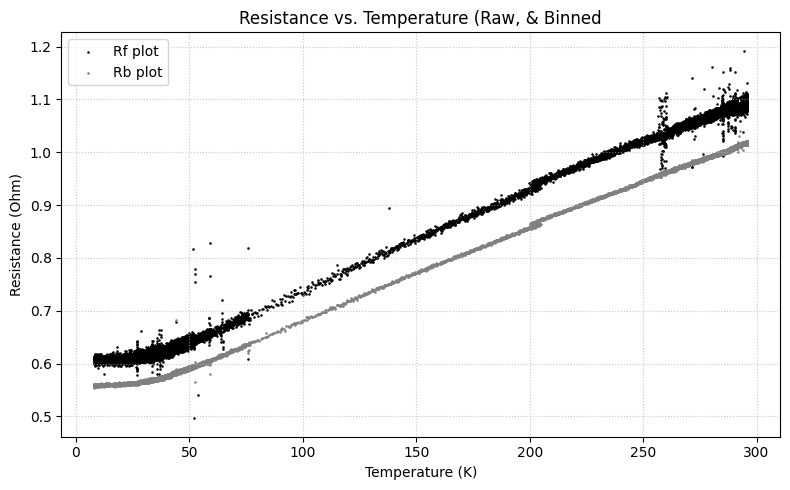

Text(0.5, 1.0, 'Sheet Resistance vs. Temperature')

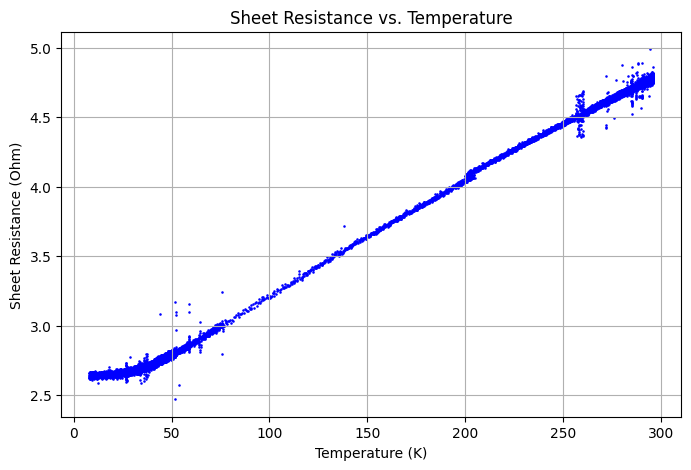

In [99]:
file_path = "DataSets/heating_8_to_296.dat"

# Load the data using pandas.
# sep='\s+' handles one or more spaces as delimiters.
# header=None indicates no header row.
# skipinitialspace=True handles potential leading spaces.
df = pd.read_csv(file_path, sep=r'\s+', header=None, skipinitialspace=True)

# The last row in your data might be incomplete. Remove any rows with NaN values if they appear.
df = df.dropna()

# front_temp (Column 6 -> index 5)
# front_temp_fluct (Column 7 -> index 6)
# front_R (Column 8 -> index 7)
# back_temp (Column 17 -> index 16)
# back_temp_fluct (Column 18 -> index 17)
# back_R (Column 19 -> index 18)

front_temp_raw = df.iloc[:, 5].astype(float)
front_temp_fluct_raw = df.iloc[:, 6].astype(float)
front_R = df.iloc[:, 7].astype(float)

back_temp_raw = df.iloc[:, 16].astype(float)
back_temp_fluct_raw = df.iloc[:, 17].astype(float)
back_R = df.iloc[:, 18].astype(float)

avg_temp = df.iloc[:, 26].astype(float)  


# # ---------------------------------------------
intra_cutoff = 0 # 30 mK
inter_cutoff = 0 # 10 uK

# # Create mask for filtering
sel_mask = (
    (front_temp_raw > 8) & (back_temp_raw > 8) &
    (front_temp_fluct_raw <= intra_cutoff) & (back_temp_fluct_raw <= intra_cutoff) & 
    (abs(front_temp_raw - back_temp_raw) == inter_cutoff)
)

# # Apply mask
Rf = front_R[sel_mask].values
Rb = back_R[sel_mask].values
Tavg = avg_temp[sel_mask].values
Tf = front_temp_raw[sel_mask].values
Tb = back_temp_raw[sel_mask].values

print(len(Tf))
print(len(Tb))

i=0
for i in range(len(Tf)):
    if (abs(Tf[i]-Tb[i])>0) : print(i)


# # ---------------------------------------------
Rs = np.zeros(len(Rf))
i = 0
while i < len(Rf):
    Rs[i] = calculate_sheet_resistance_vdp(Rf[i], Rb[i])
    i += 1  


# # ---------------------------------------------
plt.figure(figsize=(8, 5))
#plt.scatter(Tavg, Rf, s=10, label="Rf scatter", alpha=0.6)
plt.scatter(Tf, Rf, s = .7, color='black', label="Rf plot")
#plt.scatter(Tavg, Rb, s=10, label="Rb scatter", alpha=0.6)
plt.scatter(Tb, Rb, s = .7, color='gray', label="Rb plot")
plt.xlabel("Temperature (K)")
plt.ylabel("Resistance (Ohm)")
plt.title("Resistance vs. Temperature (Raw, & Binned")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()


# # ---------------------------------------------
plt.figure(figsize=(8, 5))
plt.grid()
plt.scatter(Tf, Rs, s = .7, color='blue', label='Sheet Resistance (VdP)')
plt.xlabel("Temperature (K)")
plt.ylabel("Sheet Resistance (Ohm)")
plt.title("Sheet Resistance vs. Temperature")

### $\rho_0$

Rho_0:  [2.64270235]
Rho_0 uncertainty: [0.4624039]


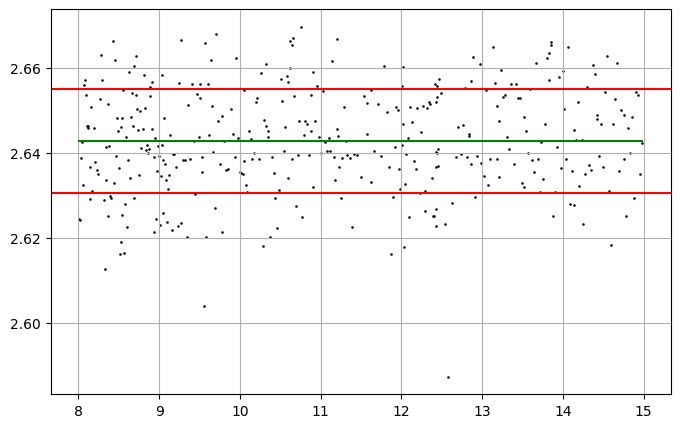

In [106]:
T_sub = []
Rs_sub = []

i=0
while (Tf[i]<15): 
    T_sub.append(Tf[i])
    Rs_sub.append(Rs[i])
    i+=1

coeff = np.polyfit(T_sub, Rs_sub, deg=0)
Rho_0 = coeff
uncertainty_Rho0 = np.std(Rs_sub)

print("Rho_0: ", Rho_0)
print("Rho_0 uncertainty:", (uncertainty_Rho0/Rho_0)*100)

plt.figure(figsize=(8, 5))
plt.grid()
plt.plot(T_sub, np.polyval(coeff, T_sub), color='green', label='Fit: Rho_0')
plt.axhline(Rho_0 + uncertainty_Rho0, color='red', linewidth=1.5)
plt.axhline(Rho_0 - uncertainty_Rho0, color='red', linewidth=1.5)
plt.scatter(T_sub, Rs_sub, s = .7, color='black', label="Rf plot")

### $\rho_{300}$

Delta_a = 6.693110110728548e-05
Delta_b = 0.01935786706636744 

Rho_300 = 4.670027005442278
Rho_300 uncertainty = 0.03809878306361411


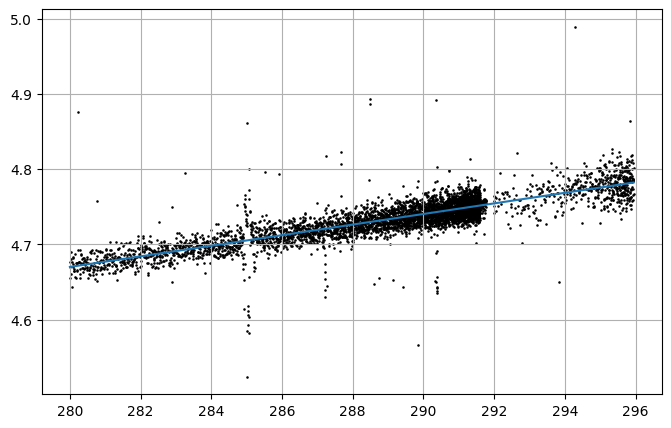

In [ ]:
T_sub_up = []
Rs_sub_up = []

i= len(Tf)-1
while (Tf[i]>280): 
    T_sub_up.append(Tf[i])
    Rs_sub_up.append(Rs[i])
    i-=1

coeff_up = np.polyfit(T_sub_up, Rs_sub_up, deg=1, cov = True)
a, cov = coeff_up
stddev_a = np.sqrt(np.diag(cov))

k = len(T_sub_up)-1
Rho_300 = np.poly1d(coeff_up[0])(T_sub_up)[k]
print('Delta_a =', stddev_a[0])
print('Delta_b =', stddev_a[1], '\n')
print('Rho_300 =', Rho_300)

uncertainty_Rho300 = T_sub_up[k]*stddev_a[0] + stddev_a[1]
print('Rho_300 uncertainty =', uncertainty_Rho300)

#stddev = np.std(Rs_sub)
plt.figure(figsize=(8, 5))
plt.grid()
plt.plot(T_sub_up, np.poly1d(coeff_up[0])(T_sub_up))
plt.scatter(T_sub_up, Rs_sub_up, s = .7, color='black', label="Rf plot")

The uncertainty model is the following: $\delta R(T) = T \delta a + \delta b$

$  \delta R (T) = \sum_i |\frac{\partial R}{\partial x_i}| \delta x_i$    given    $ R(T) = aT+b$

In [ ]:
RRR=Rho_300/Rho_0
print('RRR =', RRR)

uncertainty_RRR = ((uncertainty_Rho300/Rho_300) + (uncertainty_Rho0/Rho_0))*RRR
print('RRR uncertainty:', uncertainty_RRR)

RRR = [1.76714075]
RRR uncertainty: [0.02258793]


Functions to compute meanigful parameters to evaluate the quality of the fit


In [ ]:
def reduced_chi_squared(y_obs, y_model, y_err, num_params):
    """
    Compute the reduced chi-squared statistic.

    Parameters:
    -----------
    y_obs : array_like
        Observed y-values (data)
    y_model : array_like
        Predicted y-values from your model
    y_err : array_like
        Uncertainties (errors) on the observed y-values
    num_params : int
        Number of fitted parameters in the model

    Returns:
    --------
    float
        Reduced chi-squared
    """
    residuals = (y_obs - y_model) / y_err
    chi2 = np.sum(residuals**2)
    dof = len(y_obs) - num_params
    return chi2 / dof


def r_squared(y_obs, y_model):
    """
    Compute the coefficient of determination R².

    Parameters:
    -----------
    y_obs : array_like
        Observed y-values (data)
    y_model : array_like
        Predicted y-values from the model

    Returns:
    --------
    float
        R² value (coefficient of determination)
    """
    ss_res = np.sum((y_obs - y_model) ** 2)              # residual sum of squares
    ss_tot = np.sum((y_obs - np.mean(y_obs)) ** 2)       # total sum of squares
    return 1 - (ss_res / ss_tot)


## Fixing $n$ by generating the $ln(\rho-\rho_0)$ vs $ln(T)$ fit

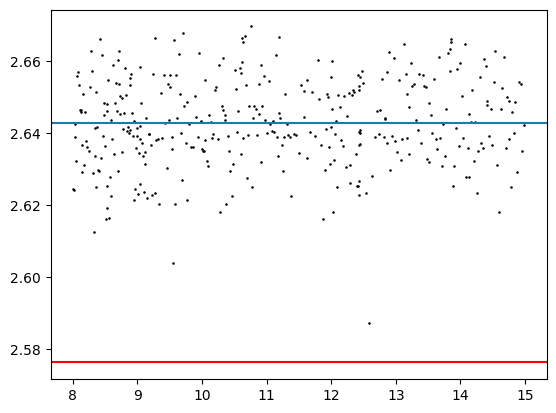

In [ ]:
#define epsilon as 
max_deltaRs = 0
for i in range(len(T_sub)):
    if ((Rs[i]-Rho_0)<0 and np.abs(Rs[i]-Rho_0)> max_deltaRs): max_deltaRs = np.abs(Rs[i]-Rho_0) + .2*np.abs(Rs[i]-Rho_0)

plt.scatter(T_sub, Rs_sub, s = .7, color='black', label="Rf plot")
plt.axhline(Rho_0)
plt.axhline(Rho_0-max_deltaRs, color = 'red')

Text(0.5, 1.0, 'Sheet Resistance vs. Temperature')

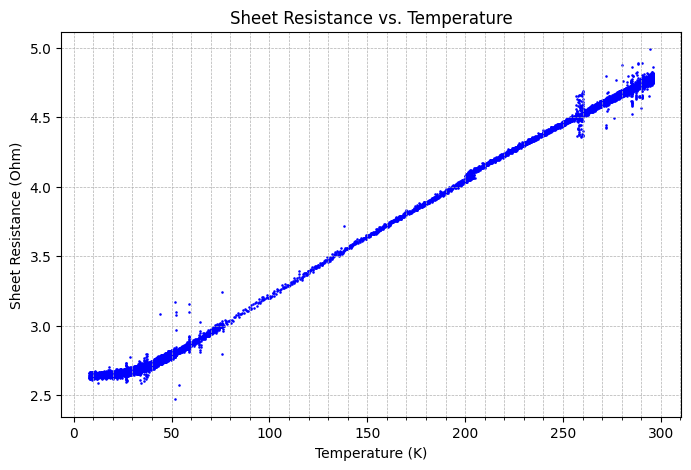

In [ ]:
# We start from this curve

from matplotlib.ticker import AutoMinorLocator

plt.figure(figsize=(8, 5))
ax = plt.gca() # Get current axes
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.scatter(Tf, Rs, s = .7, color='blue', label='Sheet Resistance (VdP)')
plt.xlabel("Temperature (K)")
plt.ylabel("Sheet Resistance (Ohm)")
plt.title("Sheet Resistance vs. Temperature")

c:\Users\feder\miniconda3\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\feder\miniconda3\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\feder\miniconda3\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\feder\miniconda3\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\feder\miniconda3\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\feder\miniconda3\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\feder\miniconda3\Lib

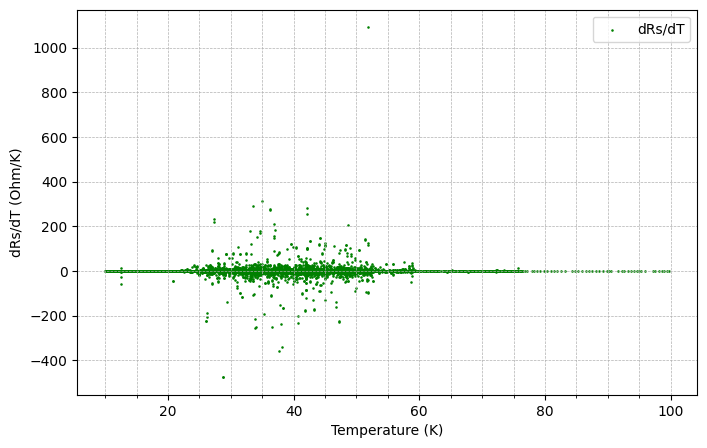

In [ ]:
# Select the data from 10 to 100K
Rs_first = []
Tf_first = []
for i in range(len(Tf)):
    if (Tf[i] >= 10 and Tf[i] <= 100):
        Rs_first.append(Rs[i])
        Tf_first.append(Tf[i])

# Find where derivative changes significantly
dRs_dT = np.gradient(Rs_first, Tf_first)
plt.figure(figsize=(8, 5))
ax = plt.gca() # Get current axes
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.scatter(Tf_first, dRs_dT, s = .7, color='green', label='dRs/dT')
plt.xlabel("Temperature (K)")
plt.ylabel("dRs/dT (Ohm/K)")
plt.legend()


n = 3.4761945244005634
n uncertainty =  0.01967046729883027


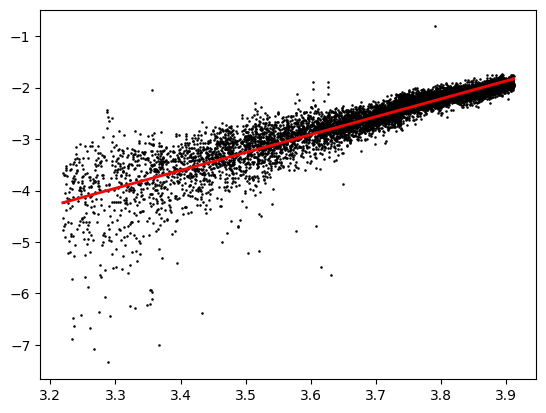

In [ ]:
# Filter the first portion of the curve
logT = []
logRR0 = []
T_comp = []
Rs_comp = []
t_u = 50
t_l = 25
i=0

while (Tf[i]<t_u): 

    if (Tf[i]>t_l):
        T_comp.append(Tf[i])
        Rs_comp.append(Rs[i])
        # logT.append(np.log(Tf[i]))
        # logRR0.append(np.log(np.abs(Rs[i] - Rho_0)))

        if (Rs[i]-Rho_0)>0:
            logT.append(np.log(Tf[i]))
            logRR0.append(np.log(Rs[i]- Rho_0))
    i+=1

# Perform the fit
coeff_log = np.polyfit(logT, logRR0, deg=1, cov = True)
params, cov = coeff_log

params = np.squeeze(params)
cov = np.squeeze(cov)
n = params[0]
print('n =', n)
print('n uncertainty = ', np.sqrt(cov[0][0]))

plt.scatter(logT, logRR0, s = .7, color='black', label="Rf plot")
plt.plot(logT, np.poly1d(params)(logT), linewidth = 2, color = 'red')

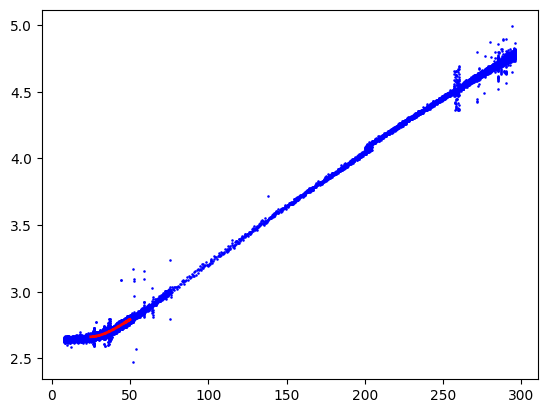

In [ ]:
coeff_cmp = np.polyfit(T_comp, Rs_comp, deg=n)
params = coeff_cmp

plt.scatter(T_comp, Rs_comp, s = .7, color='blue' )
plt.plot(T_comp, np.poly1d(coeff_cmp)(T_comp), linewidth = 2, color = 'red')
plt.scatter(Tf, Rs, s = .7, color='blue' )

## Bloch-Grüneisen Fit

Initial guess: A=0.235, θ_R=148.0, n=2.00, Rs_0=2.643


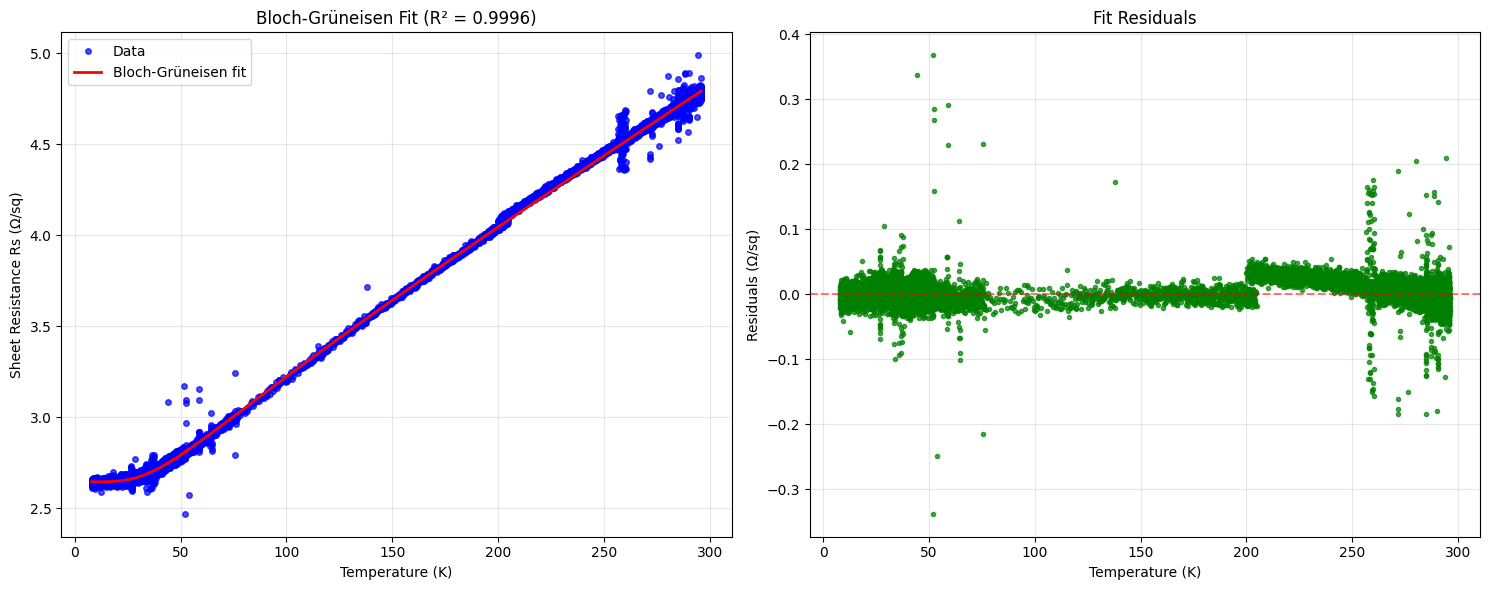


BLOCH-GRÜNEISEN FIT RESULTS
A = 7.962096 ± 0.448368
θ_R = 212.81 ± 2.32 K
n = 6.000 ± 0.336
Rs_0 = 2.644924 ± 0.000667 Ω/sq
R² = 0.999626


In [115]:
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

def bloch_gruneisen_integrand(t, n):
    if t < 1e-10:
        return 0
    
    if t > 100:
        return t**n * np.exp(-t)
    
    try:
        exp_t = np.exp(t)
        exp_minus_t = np.exp(-t)
        denominator = (exp_t - 1) * (1 - exp_minus_t)
        
        if denominator > 0:
            return t**n / denominator
        else:
            return 0
    except:
        return 0

def bloch_gruneisen_integral(theta_R_over_T, n):
    if theta_R_over_T <= 0:
        return 0
    
    # Adaptive quadrature
    try:
        result, _ = quad(bloch_gruneisen_integrand, 0, theta_R_over_T, 
                        args=(n,), limit=100, epsabs=1e-8, epsrel=1e-6)
        return result
    except:
        # Manual integration fallback
        t_vals = np.linspace(0, theta_R_over_T, 1000)
        integrand_vals = [bloch_gruneisen_integrand(t, n) for t in t_vals]
        return np.trapz(integrand_vals, t_vals)

def bloch_gruneisen_model(T, A, theta_R, n, Rs_0):
    Rs = np.zeros_like(T)
    
    for i, temp in enumerate(T):
        if temp <= 0:
            Rs[i] = Rs_0
            continue
            
        # Calculate θ_R/T
        theta_R_over_T = theta_R / temp
        
        # Calculate the integral
        integral_value = bloch_gruneisen_integral(theta_R_over_T, n)
        
        # Calculate resistance
        Rs[i] = Rs_0 + A * (temp / theta_R)**n * integral_value
    
    return Rs

def fit_bloch_gruneisen(T, Rs, n_initial_guess, Rs_0_guess=None):
    if Rs_0_guess is None:
        Rs_0_guess = 2.64270235
    
    A_guess = (np.max(Rs) - Rs_0_guess) / 10
    theta_R_guess = np.max(T) / 2  # Rough estimate
    
    # Parameter bounds
    bounds = (
        [0, 10, 0.1, 0],  # Lower bounds: [A, theta_R, n, Rs_0]
        [np.inf, 300, 6, 3]  # Upper bounds
    )
    
    p0 = [A_guess, theta_R_guess, n_initial_guess, Rs_0_guess]
    
    print(f"Initial guess: A={A_guess:.3f}, θ_R={theta_R_guess:.1f}, n={n_initial_guess:.2f}, Rs_0={Rs_0_guess:.3f}")
    
    try:
        popt, pcov = curve_fit(bloch_gruneisen_model, T, Rs, p0=p0, bounds=bounds, 
                              maxfev=5000, method='trf')
        
        param_errors = np.sqrt(np.diag(pcov))
        
        # R²
        Rs_fit = bloch_gruneisen_model(T, *popt)
        ss_res = np.sum((Rs - Rs_fit)**2)
        ss_tot = np.sum((Rs - np.mean(Rs))**2)
        r_squared = 1 - (ss_res / ss_tot)

        # Chi-squared
        num_params = len(popt)
        y_err = np.std(Rs) * np.ones_like(Rs)  # Assuming constant error for simplicity
        chi_squared = reduced_chi_squared(Rs, Rs_fit, y_err, num_params)
        
        return popt, param_errors, r_squared, Rs_fit
        
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None, None, None, None

def plot_fit_results(T, Rs, Rs_fit, popt, param_errors, r_squared):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Main
    ax1.plot(T, Rs, 'bo', markersize=4, label='Data', alpha=0.7)
    ax1.plot(T, Rs_fit, 'r-', linewidth=2, label='Bloch-Grüneisen fit')
    ax1.set_xlabel('Temperature (K)')
    ax1.set_ylabel('Sheet Resistance Rs (Ω/sq)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_title(f'Bloch-Grüneisen Fit (R² = {r_squared:.4f})')
    
    # Residuals
    residuals = Rs - Rs_fit
    ax2.plot(T, residuals, 'go', markersize=3, alpha=0.7)
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Temperature (K)')
    ax2.set_ylabel('Residuals (Ω/sq)')
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Fit Residuals')
    
    plt.tight_layout()
    plt.show()
    
    # Print
    A, theta_R, n, Rs_0 = popt
    dA, dtheta_R, dn, dRs_0 = param_errors
    
    print("\n" + "="*50)
    print("BLOCH-GRÜNEISEN FIT RESULTS")
    print("="*50)
    print(f"A = {A:.6f} ± {dA:.6f}")
    print(f"θ_R = {theta_R:.2f} ± {dtheta_R:.2f} K")
    print(f"n = {n:.3f} ± {dn:.3f}")
    print(f"Rs_0 = {Rs_0:.6f} ± {dRs_0:.6f} Ω/sq")
    print(f"R² = {r_squared:.6f}")
    print("="*50)
    
# Fit the model
popt, param_errors, r_squared, Rs_fit = fit_bloch_gruneisen(Tf, Rs, n_initial_guess=2)

if popt is not None:
    plot_fit_results(Tf, Rs, Rs_fit, popt, param_errors, r_squared)